# TODO
* Evaluer erreurs
* Voir les associations mots->classe
* Voir les ech. qui activent certaines classes

In [31]:
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.utils import to_categorical
from keras.regularizers import l2

from sklearn.metrics import classification_report

import classif

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
def build_model(num_classes, l2_reg):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64,), gamma_regularizer=l2(l2_reg)))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg)))
    
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
    return model


def train(model: Sequential, data, gen=None, verbose=1, epochs=10):
    print('Training...')
    if gen:
        history = model.fit_generator(gen(), 100, epochs=epochs, verbose=verbose,
                                      validation_data=(data['X_val'], data['y_val']))
    else:
        history = model.fit(data['X_train'], data['y_train'],
                            validation_data=(data['X_val'], data['y_val']),
                            verbose=verbose)
    
    return np.max(history.history['val_acc'])
    

def test(model: Sequential, data):
    print('Testing...')
    results = model.evaluate(data['X_test'], data['y_test'])
    print('\nLoss: {}  Acc: {}'.format(*results))

    
data, num_classes, gen = classif.load_data()
q_labels = ['Démocratie: Comment reprendre le pouvoir?',
'Économie: Comment développer le Québec selon nos priorités?',
'Régions: Comment dynamiser toutes nos communautés?',
'Indépendance: Comment se remettre en marche?',
'Éducation: Comment permettre à tout le monde de réaliser son plein potentiel?',
'Premiers Peuples: Comment construire la solidarité entre nous?',
'Diversité: Comment vivre ensemble sans racisme ni discrimination?',
'Culture: Comment favoriser une création artistique vivante et en assurer l’accès à tous?',
'Santé: Comment prendre soin de tout le monde?',
'Climat: Comment enclencher la transition?',
'On a oublié quelque chose?']

N train, val, test: 3172 317 1799
Bin count train:  [811 143 425  48 783  71  22  99 191 579]
Bin count val:    [70 17 43  4 82 13  4 11 14 59]
Bin count test:   [467  98 215  21 491  43  14  39  93 318]


In [60]:
# Perform grid search
# best l2_reg = 0.01
reg_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = {}

for reg in reg_list:
    print('Trying reg=' + str(reg))
    model = build_model(num_classes, reg)
    val_acc = train(model, data, gen, verbose=0, epochs=40)
    print('Val acc: ' + str(val_acc))
    results[reg] = val_acc

Trying reg=1e-06
Training...
Using gen
Val acc: 0.848580443709
Trying reg=1e-05
Training...
Using gen
Val acc: 0.82965299929
Trying reg=0.0001
Training...
Using gen
Val acc: 0.813880126935
Trying reg=0.001
Training...
Using gen
Val acc: 0.804416402845
Trying reg=0.01
Training...
Using gen
Val acc: 0.574132493618
Trying reg=0.1
Training...
Using gen
Val acc: 0.359621450258


In [61]:
# Train best model
model = build_model(num_classes, 1e-6)
train(model, data, gen, epochs=40)

Training...
Using gen
Epoch 1/40
100/100 [==============================] - 5s - loss: 2.0771 - acc: 0.3756 - val_loss: 2.0835 - val_acc: 0.2776
Epoch 2/40
100/100 [==============================] - 0s - loss: 1.6118 - acc: 0.4862 - val_loss: 1.7261 - val_acc: 0.4227
Epoch 3/40
100/100 [==============================] - 0s - loss: 1.4703 - acc: 0.5328 - val_loss: 1.5102 - val_acc: 0.4606
Epoch 4/40
100/100 [==============================] - 0s - loss: 1.3213 - acc: 0.5863 - val_loss: 1.5593 - val_acc: 0.4826
Epoch 5/40
100/100 [==============================] - 1s - loss: 1.1865 - acc: 0.6206 - val_loss: 1.4209 - val_acc: 0.5584
Epoch 6/40
100/100 [==============================] - 1s - loss: 1.1475 - acc: 0.6272 - val_loss: 1.3285 - val_acc: 0.5457
Epoch 7/40
100/100 [==============================] - 1s - loss: 1.1090 - acc: 0.6512 - val_loss: 1.6228 - val_acc: 0.5142
Epoch 8/40
100/100 [==============================] - 1s - loss: 1.0672 - acc: 0.6584 - val_loss: 1.3086 - val_acc: 0

0.81703470275981194

In [64]:
y_pred = model.predict(data['X_test'])
y_pred = to_categorical(np.argmax(y_pred, axis=1), num_classes)
test_acc = np.mean(y_pred == data['y_test'])
print('Test accuracy: ' + str(test_acc))
print(classification_report(data['y_test'], y_pred))

Test accuracy: 0.961423012785
             precision    recall  f1-score   support

          0       0.90      0.78      0.83       451
          1       0.84      0.93      0.88        84
          2       0.72      0.77      0.75       242
          3       0.74      0.94      0.83        34
          4       0.79      0.72      0.75       450
          5       0.84      0.95      0.89        38
          6       0.59      1.00      0.74        13
          7       0.84      0.98      0.90        57
          8       0.72      0.88      0.79        96
          9       0.82      0.88      0.85       334

avg / total       0.81      0.81      0.81      1799



In [92]:
import word2vec
import matplotlib.pyplot as plt
embedder = word2vec.Embedder()

Embedding answers...


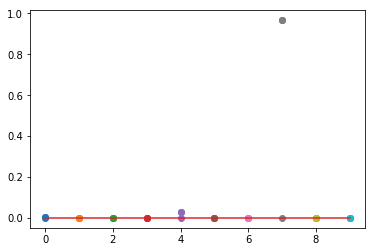

Culture: Comment favoriser une création artistique vivante et en assurer l’accès à tous?


In [116]:
test_ans = embedder.embed_phrase('Soutenir les poètes, philosophes et écrivains')
y_pred = model.predict(test_ans[None, :])
plt.figure()
plt.stem(y_pred.ravel(), 'o')
plt.show()
y_pred = np.argmax(y_pred, axis=1)
print(q_labels[int(y_pred)])